# Reddit toxic comment classifier
## Model evaluation and selection

### John Burt

[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/springboard/blob/master/capstone_1/reddit_toxic_comment_detection_model_selection_v1.ipynb) 

### Introduction:

Here, I compare the performance of four classifier models across comment datasets from the 12 subreddits. The model performance data used for this analysis was logged during validation runs. For a metric, I chose balanced accuracy. Since this was a binary classification problem, a score of 50% was equivalent to a random prediction, and scores above that are better. 

When evaluating model performance, I was looking at which models had the highest scores, but also how variable the models were: it wouldn't do for a model to perform very well with certain datasets, but very poorly with others.



In [35]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


### Notebook setup and load validation logs

In [36]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-muted')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime

# source data folder 
srcdir = './data_for_models/'

# results logfile path
logpath = srcdir + 'model_results_log.csv'

# read the validation run output logs
df = pd.read_csv(logpath)


### Mean and SEM classifier performance for all subreddits

Looking at overall model performance for all subreddits, several results particularly stand out:

- None of the models performed very well. The model with the highest balanced accuracy was XGBoost (65%) , and lowest was RNN (62%). 


- XGBoost performed best, but performed the most variably across subreddits (SEM +/- 2.5%), while the worst performer, RNN, has the lowest variability across subreddits (SEM +/- 1.2%). The other two models also had higher variance than RNN. 


           model       mean       SEM
0  MultinomialNB  63.063095  2.338969
1            RNN  61.973889  1.151472
2   RandomForest  63.884127  2.709170
3  XGBClassifier  65.208333  2.471913


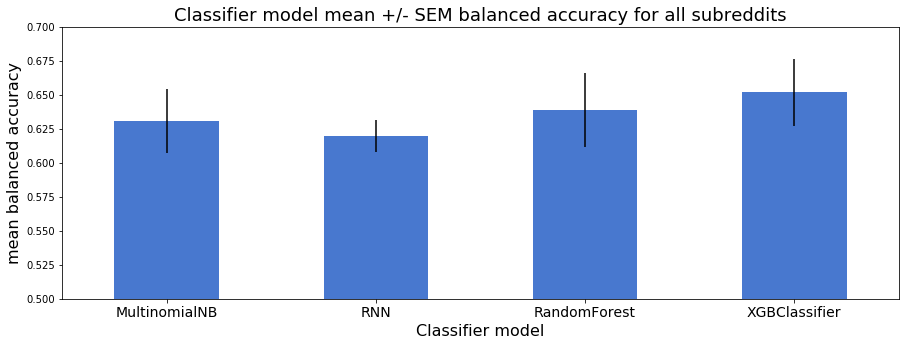

In [37]:
df_pivot = df.pivot_table(index='model', columns ='sub', values='balanced_acc', aggfunc='mean')

df_stats = pd.DataFrame({'mean':df_pivot.mean(axis=1)*100, 'SEM':df_pivot.std(axis=1)/np.sqrt(12)*100})
df_stats = df_stats.reset_index()
print(df_stats)

fig, ax = plt.subplots(figsize=(15,5))
df_pivot.mean(axis=1).plot.bar(ax=ax, yerr=df_pivot.std(axis=1)/np.sqrt(12))
plt.ylim([.5,.7])
plt.ylabel('mean balanced accuracy', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.xlabel('Classifier model', fontsize=16)
# ax.set_facecolor('white')
plt.title('Classifier model mean +/- SEM balanced accuracy for all subreddits', fontsize=18);

### How do models perform across subreddits?

Looking at how models performed across all subreddits revealed some interesting trends. 

- Each model performed differently with different subreddits. For example, the RNN performed much better than all other models on r/science, but was much poorer than the others on r/politicaldiscussion. The lowest model/sub score was 52% (RandomForest/science) and the highest was 81% (RandomForest/the_donald).


- The models MultinomialNB, RandomForest and XGBClassifier performed most similarly, while RNN often performed well when the others had poor balanced accuracy, and vice versa. That the first three models performed similarly is not surprising - they all used the same feature data, whereas the RNN had a very different data transformation process. 

model                MultinomialNB  RandomForest  XGBClassifier       RNN
sub                                                                      
aww                       0.716238      0.693429       0.707000  0.635867
funny                     0.653333      0.638000       0.665667  0.649000
todayilearned             0.733000      0.734000       0.728667  0.586000
askreddit                 0.586000      0.545333       0.568000  0.664000
photography               0.571000      0.557667       0.573667  0.641000
gaming                    0.563000      0.568333       0.591333  0.663333
videos                    0.559667      0.562333       0.596000  0.650333
science                   0.520667      0.516667       0.521000  0.636000
politics                  0.540667      0.608333       0.635667  0.620667
politicaldiscussion       0.725000      0.742333       0.755667  0.552000
conservative              0.690667      0.688667       0.680000  0.563667
the_Donald                0.708333    

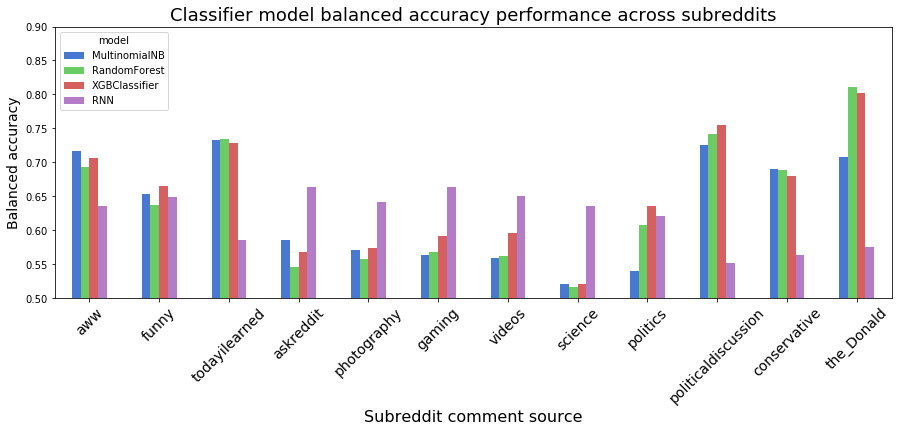

In [38]:
# group logs by model and subreddit
df_gr = df.groupby(['sub','model'], sort=False).mean()
df_gru = df_gr.unstack()
print(df_gru['balanced_acc'])

fig, ax = plt.subplots(figsize=(15,5))
df_gru['balanced_acc'].plot.bar(ax=ax)
plt.ylim([.5,.9])
plt.ylabel('Balanced accuracy', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Subreddit comment source', fontsize=16)
# ax.set_facecolor('white')
plt.title('Classifier model balanced accuracy performance across subreddits', fontsize=18);

### Effect of total sample size on classifier performance

It's possible that some of the variation in classifier performance was due to the different sample sizes of each of the subreddits (max = gaming at 129982, min = conservative at 41434 samples total). I plotted balanced accuracy against total sample size for each subreddit and classifier type. If overall sample size predicts model performance, there should be a significant positive correlation, but that was not the case for any of the models.

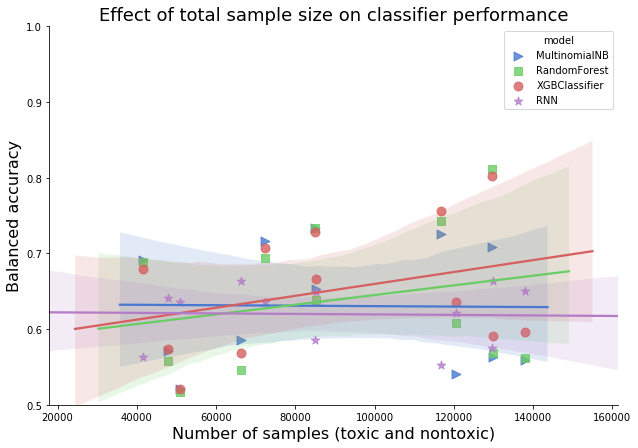

In [39]:
df_grni = df_gr.reset_index()

df_grni['num_all'] = df_grni['num_toxic'] + df_grni['num_nontoxic']

markers = ['>', 's', 'o', '*']

lm = sns.lmplot( x='num_all',y='balanced_acc', data=df_grni, 
            hue='model', legend=True, legend_out=False,
            scatter_kws={"s": 80}, order=1, markers=markers,
            height=6, aspect=1.5)
plt.ylim(.5,1)
plt.title('Effect of total sample size on classifier performance', fontsize=18)
plt.xlabel('Number of samples (toxic and nontoxic)', fontsize=16)
plt.ylabel('Balanced accuracy', fontsize=16);


### Effect of toxic sample size on classifier performance

Even if total training sample size had no impact, it could be that the number of toxic-labelled samples was important  to model performance. I plotted balanced accuracy against number of toxic-labelled samples for each subreddit and classifier type. This produced interesting and puzzling results: three models, MultinomialNB, RandomForest and XGBClassifier, performed better when there were more toxic-labelled samples, but the RNN performed __worse__ when there were more toxic-labelled samples.

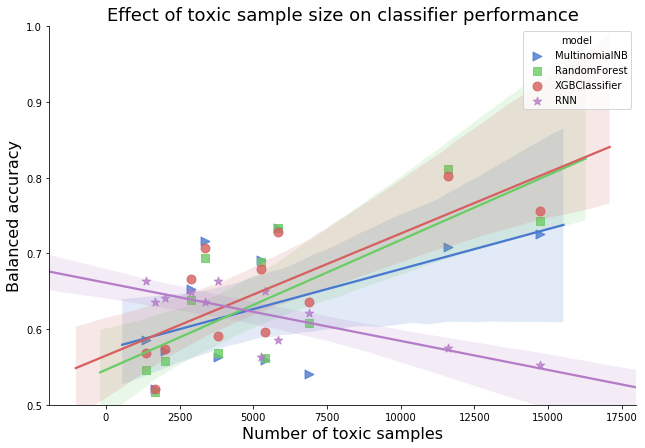

In [40]:
import seaborn as sns

markers = ['>', 's', 'o', '*']

lm = sns.lmplot( x='num_toxic',y='balanced_acc', data=df_grni, 
            hue='model', legend=True, legend_out=False,
            scatter_kws={"s": 80}, order=1, markers=markers,
            height=6, aspect=1.5)
plt.ylim(.5,1)
plt.title('Effect of toxic sample size on classifier performance', fontsize=18)
plt.xlabel('Number of toxic samples', fontsize=16)
plt.ylabel('Balanced accuracy', fontsize=16);

    

### Effect of toxic sample percentage on classifier performance

To further examine the effect of toxic-labelled sample size on model performance, I plotted balanced accuracy against the percentage of toxic-labelled comments in each subreddit dataset. This controls for overall sample size effect. I found an even stronger and similar effect: MultinomialNB, RandomForest and XGBClassifier performed better when there was a higher proportion of toxic-labelled samples, while the RNN performed worse. In fact, RNN shows a vey tight negative linear relationship with toxic-labelled sample proportion.

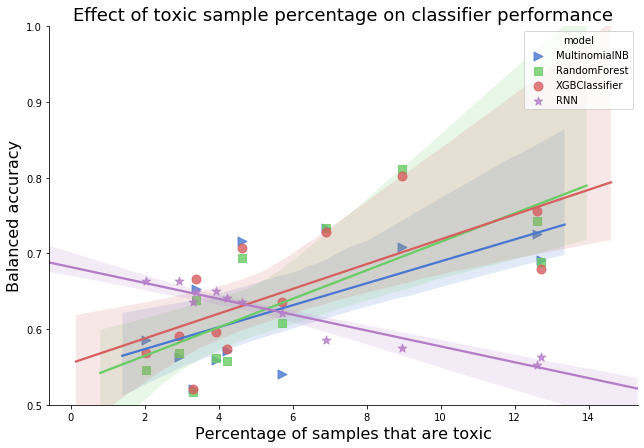

In [41]:
df_grni['cat_pct_toxic'] = 100 * df_grni['num_toxic'] / (df_grni['num_toxic']+df_grni['num_nontoxic']) 

markers = ['>', 's', 'o', '*']

lm = sns.lmplot( x='cat_pct_toxic',y='balanced_acc', data=df_grni, 
            hue='model', legend=True, legend_out=False,
            scatter_kws={"s": 80}, order=1, markers=markers,
            height=6, aspect=1.5)
plt.ylim(.5,1)
plt.title('Effect of toxic sample percentage on classifier performance', fontsize=18)
plt.xlabel('Percentage of samples that are toxic', fontsize=16)
plt.ylabel('Balanced accuracy', fontsize=16);
